In [22]:
import scipy.io
import pandas as pd
import numpy as np
import math
import time
from matplotlib import pyplot as plt

### Prepare Data

Download [Xenium data](https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast) from 10x website and save them as `h5ad` file

In [6]:
a =pd.read_csv("/mnt/scratch1/spatial_compare/public_data/xenium_breast/outs/xenium_breast_r1.csv")
cells_metadata = pd.read_csv('/mnt/scratch1/spatial_compare/public_data/xenium_breast/outs/cells.csv.gz')
a['cell_id']=a['Barcode']
merged_df = pd.merge(a, cells_metadata, on='cell_id', how='inner') 
merged_df

,Barcode,Cluster,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area
0,1,DCIS_2,1,847.259912,326.191365,28,1,0,29,58.387031,26.642187
1,2,DCIS_2,2,826.341995,328.031830,94,0,0,94,197.016719,42.130781
2,3,Unlabeled,3,848.766919,331.743187,9,0,0,9,16.256250,12.688906
3,4,Invasive_Tumor,4,824.228409,334.252643,11,0,0,11,42.311406,10.069844
4,5,DCIS_2,5,841.357538,332.242505,48,0,0,48,107.652500,37.479687
...,...,...,...,...,...,...,...,...,...,...,...
167775,167776,DCIS_1,167776,7455.475342,5114.875415,229,1,0,230,220.452812,60.599688
167776,167777,DCIS_2,167777,7483.727051,5111.477490,79,0,0,79,37.389375,25.242344
167777,167778,DCIS_1,167778,7470.159424,5119.132056,397,0,0,397,287.058281,86.700000
167778,167779,DCIS_2,167779,7477.737207,5128.712817,117,0,0,117,235.354375,25.197187


In [11]:
merged_df.shape

(167780, 11)

In [13]:

exp = scipy.io.mmread('/mnt/scratch1/spatial_compare/public_data/xenium_breast/outs/cell_feature_matrix/matrix.mtx.gz').toarray()
cols = pd.read_csv('/mnt/scratch1/spatial_compare/public_data/xenium_breast/outs/cell_feature_matrix/barcodes.tsv.gz', header=None, sep='\t')
rows = pd.read_csv('/mnt/scratch1/spatial_compare/public_data/xenium_breast/outs/cell_feature_matrix/features.tsv.gz', header=None, sep='\t')
# Extract gene and cell identifiers
row_names = rows.iloc[:, 1].values  # Gene symbols
col_names = cols.iloc[:, 0].values  # Barcodes (cell IDs)

# Convert to DataFrame
exp = pd.DataFrame(exp, columns=col_names, index=row_names)

#

In [14]:
adata = ad.AnnData(
    X=exp.values.T,  # Transpose for cells x genes
    obs=merged_df,  # Align metadata with cells
    var=pd.DataFrame(index=row_names)  # Add gene symbols
)

# Add morphology or spatial metadata (if available)
adata.uns["spatial"] = {
    "morphology_mip": "/mnt/scratch1/spatial_compare/public_data/xenium_breast/morphology_mip.ome.tif",
    "morphology_focus": "/mnt/scratch1/spatial_compare/public_data/xenium_breast/morphology_focus.ome.tif",
}

# Add additional gene metadata if needed
adata.var['gene_ids'] = rows.iloc[:, 0].values  # Add gene IDs
adata.var['feature_type'] = rows.iloc[:, 2].values  # Add feature type


/mnt/scratch1/miniconda3/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
adata

AnnData object with n_obs × n_vars = 167780 × 541
    obs: 'Barcode', 'Cluster', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_type'
    uns: 'spatial'

### Test Spatial_Detection_Score

`cell_type` information is from 10x `Cell_Barcode_Type_Matrices.xlsx` 

In [17]:
data['cell_type']=data['Cluster']

In [18]:
# Create a DataFrame from AnnData
data = adata.obs

# Ensure required columns are present
if 'x_centroid' not in data.columns or 'y_centroid' not in data.columns:
    # Extract spatial coordinates from the `.h5ad` file
    data['x_centroid'] = adata.obsm['spatial'][:, 0]
    data['y_centroid'] = adata.obsm['spatial'][:, 1]

if 'transcript_counts' not in data.columns:
    # Sum up transcript counts across features for each cell
    data['transcript_counts'] = adata.X.sum(axis=1).A1 if hasattr(adata.X, 'A1') else adata.X.sum(axis=1)

# Use the cell type/cluster information as the category
if 'supercluster_name' not in data.columns:
    data['supercluster_name'] = adata.obs['cell_type']  # Replace 'cell_type' with the appropriate column

# Use the entire data as both reference and query
reference_data = data
query_data = data

In [23]:
def spatial_detection_scores(
    reference: pd.DataFrame,
    query: pd.DataFrame,
    plot_stuff=True,
    query_name: str = "query data",
    comparison_column="transcript_counts",
    category="supercluster_name",
    n_bins=50,
    in_place=True,
    non_spatial=False,
):
    """
    Calculate and plot spatial detection scores for query data compared to reference data.

    Parameters:
        reference (pd.DataFrame): The reference data.
        query (pd.DataFrame): The query data.
        plot_stuff (bool, optional): Whether to plot the results. Defaults to True.
        query_name (str, optional): The name of the query data. Defaults to "query data".
        category (str, optional): The category column to compare. Defaults to "supercluster_name".
        n_bins (int, optional): The number of bins for spatial grouping. Defaults to 50.
        in_place (bool, optional): Whether to modify the query data in place. Defaults to True.
        non_spatial (bool, optional): Whether to compare to an ungrouped mean/std. Defaults to False.

    Returns:
        dict: A dictionary containing the bin image, extent, query data, and reference data (if in_place is False).
    """
    # code goes here

    if category not in reference.columns or category not in query.columns:
        raise ValueError("category " + category + " not in reference and query inputs")

    shared_category_values = list(
        set(reference[category].unique()) & set(query[category].unique())
    )
    if (
        len(shared_category_values) < query[category].unique().shape[0]
        or len(shared_category_values) < reference[category].unique().shape[0]
    ):
        in_place = False

    if in_place:
        s2 = query.loc[query[category].isin(shared_category_values), :]
        s1 = reference.loc[reference[category].isin(shared_category_values), :]
    else:
        s2 = query.loc[query[category].isin(shared_category_values), :].copy()
        s1 = reference.loc[reference[category].isin(shared_category_values), :].copy()

    means = s1.groupby(category, observed=True)[comparison_column].mean()
    stds = s1.groupby(category, observed=True)[comparison_column].std()

    # if you want to compare to an ungrouped mean/std, try this:
    if non_spatial:
        means[:] = means.mean()
        stds[:] = stds.mean()

    s2["detection_relative_z_score"] = 0.0
    s2["detection_difference"] = 0.0
    s2["detection_ratio"] = 0.0

    for c, gb in s2.groupby(category, observed=True):
        if c not in shared_category_values:
            continue

        s2.loc[s2[category] == c, ["detection_relative_z_score"]] = (
            (s2.loc[s2[category] == c, [comparison_column]] - means[c]) / stds[c]
        ).values
        s2.loc[s2[category] == c, ["detection_difference"]] = (
            s2.loc[s2[category] == c, [comparison_column]] - means[c]
        ).values
        s2.loc[s2[category] == c, ["log_10_detection_ratio"]] = np.log10(
            (s2.loc[s2[category] == c, [comparison_column]] / means[c]).values
        )

    s2["xy_bucket"] = list(
        zip(
            pd.cut(s2.x_centroid, n_bins, labels=list(range(n_bins))),
            pd.cut(s2.y_centroid, n_bins, labels=list(range(n_bins))),
        )
    )

    binx = s2.groupby("xy_bucket").x_centroid.mean()
    biny = s2.groupby("xy_bucket").y_centroid.mean()

    z_score = s2.groupby("xy_bucket").detection_relative_z_score.mean()
    difference = s2.groupby("xy_bucket").detection_difference.mean()
    log_ratio = s2.groupby("xy_bucket").log_10_detection_ratio.mean()
    n_cells = s2.groupby("xy_bucket").x_centroid.count()

    bin_image_z_score = np.zeros([n_bins, n_bins])
    bin_image_difference = np.zeros([n_bins, n_bins])
    bin_image_ratio = np.zeros([n_bins, n_bins])
    bin_image_counts = np.zeros([n_bins, n_bins])

    extent = [np.min(binx), np.max(binx), np.min(biny), np.max(biny)]
    for coord in binx.index:
        bin_image_z_score[coord[1], coord[0]] = z_score[coord]
        bin_image_difference[coord[1], coord[0]] = difference[coord]
        bin_image_ratio[coord[1], coord[0]] = log_ratio[coord]
        bin_image_counts[coord[1], coord[0]] = n_cells[coord]

    if plot_stuff:
        if non_spatial:
            title_string = "Non-spatial Detection Scores"
        else:
            title_string = "Spatial Detection Scores"
        min_maxes = {
            "detection z-score": [bin_image_z_score, [-1, 1]],
            "total counts difference": [bin_image_difference, [-100, 100]],
            "log10(detection ratio)": [bin_image_ratio, [-1, 1]],
        }

        fig, axs = plt.subplots(1, 3, figsize=[15, 5])
        if non_spatial:
            fig.suptitle(title_string + "\n" + query_name)
        else:
            fig.suptitle(
                title_string
                + "\n"
                + query_name
                + " grouped by "
                + category
                + " and spatially binned"
            )
        for ii, plot_name in enumerate(min_maxes.keys()):
            ax = axs[ii]
            pcm = ax.imshow(
                min_maxes[plot_name][0],
                extent=extent,
                cmap="coolwarm_r",
                vmin=min_maxes[plot_name][1][0],
                vmax=min_maxes[plot_name][1][1],
            )
            fig.colorbar(pcm, ax=ax, shrink=0.7)
            ax.set_title(query_name + "\n" + plot_name)

    if in_place:

        return dict(
            z_score_image=bin_image_z_score,
            difference_image=bin_image_difference,
            ratio_image=bin_image_ratio,
            extent=extent,
            count_image=bin_image_counts,
            query=True,
            reference=True,
        )

    else:
        return dict(
            z_score_image=bin_image_z_score,
            difference_image=bin_image_difference,
            ratio_image=bin_image_ratio,
            extent=extent,
            count_image=bin_image_counts,
            query=s2,
            reference=s1,
        )


/tmp/ipykernel_757836/775244361.py:71: RuntimeWarning: divide by zero encountered in log10
  s2.loc[s2[category] == c, ["log_10_detection_ratio"]] = np.log10(


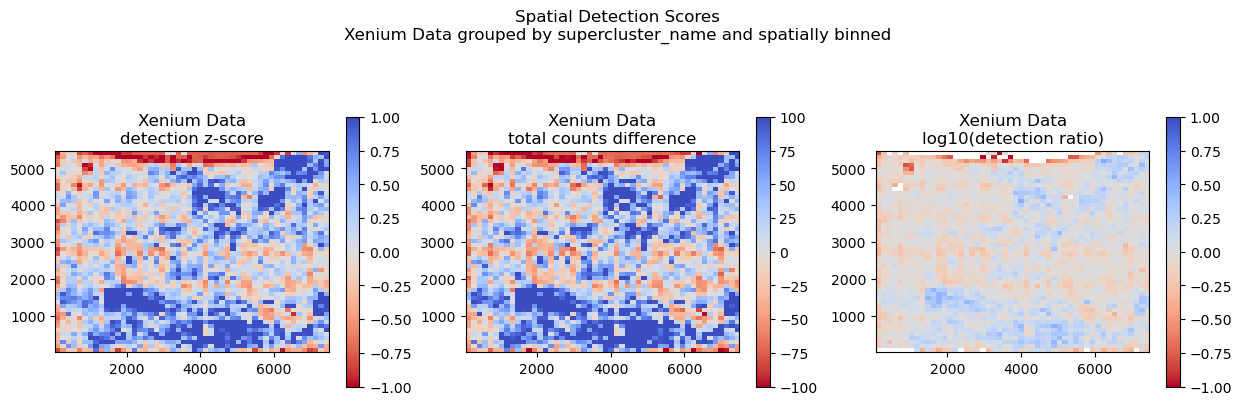

In [24]:
results = spatial_detection_scores(
    reference=reference_data,
    query=query_data,
    plot_stuff=True,
    query_name="Xenium Data",
    comparison_column="transcript_counts",
    category="supercluster_name",
    n_bins=50,
    in_place=False,
    non_spatial=False
)

In [25]:
def spatial_detection_scores_no_category(
    reference: pd.DataFrame,
    query: pd.DataFrame,
    plot_stuff=True,
    query_name: str = "query data",
    comparison_column="transcript_counts",
    n_bins=50,
    in_place=True,
    non_spatial=False,
):
    """
    Calculate and plot spatial detection scores for query data compared to reference data
    without category grouping.

    Parameters:
        reference (pd.DataFrame): The reference data.
        query (pd.DataFrame): The query data.
        plot_stuff (bool, optional): Whether to plot the results. Defaults to True.
        query_name (str, optional): The name of the query data. Defaults to "query data".
        comparison_column (str, optional): The column to compare. Defaults to "transcript_counts".
        n_bins (int, optional): The number of bins for spatial grouping. Defaults to 50.
        in_place (bool, optional): Whether to modify the query data in place. Defaults to True.
        non_spatial (bool, optional): Whether to compare to an ungrouped mean/std. Defaults to False.

    Returns:
        dict: A dictionary containing the bin image, extent, query data, and reference data (if in_place is False).
    """
    if comparison_column not in reference.columns or comparison_column not in query.columns:
        raise ValueError(f"{comparison_column} not found in reference or query data")

    if in_place:
        s2 = query.copy()
        s1 = reference
    else:
        s2 = query.copy()
        s1 = reference.copy()

    # Calculate global mean and std
    mean_val = s1[comparison_column].mean()
    std_val = s1[comparison_column].std()

    s2["detection_relative_z_score"] = (s2[comparison_column] - mean_val) / std_val
    s2["detection_difference"] = s2[comparison_column] - mean_val
    s2["log_10_detection_ratio"] = np.log10(s2[comparison_column] / mean_val)

    # Spatial binning
    s2["xy_bucket"] = list(
        zip(
            pd.cut(s2.x_centroid, n_bins, labels=list(range(n_bins))),
            pd.cut(s2.y_centroid, n_bins, labels=list(range(n_bins))),
        )
    )

    binx = s2.groupby("xy_bucket").x_centroid.mean()
    biny = s2.groupby("xy_bucket").y_centroid.mean()

    z_score = s2.groupby("xy_bucket").detection_relative_z_score.mean()
    difference = s2.groupby("xy_bucket").detection_difference.mean()
    log_ratio = s2.groupby("xy_bucket").log_10_detection_ratio.mean()
    n_cells = s2.groupby("xy_bucket").x_centroid.count()

    bin_image_z_score = np.zeros([n_bins, n_bins])
    bin_image_difference = np.zeros([n_bins, n_bins])
    bin_image_ratio = np.zeros([n_bins, n_bins])
    bin_image_counts = np.zeros([n_bins, n_bins])

    extent = [np.min(binx), np.max(binx), np.min(biny), np.max(biny)]
    for coord in binx.index:
        bin_image_z_score[coord[1], coord[0]] = z_score[coord]
        bin_image_difference[coord[1], coord[0]] = difference[coord]
        bin_image_ratio[coord[1], coord[0]] = log_ratio[coord]
        bin_image_counts[coord[1], coord[0]] = n_cells[coord]

    if plot_stuff:
        title_string = "Spatial Detection Scores (No Categories)"
        min_maxes = {
            "detection z-score": [bin_image_z_score, [-1, 1]],
            "total counts difference": [bin_image_difference, [-100, 100]],
            "log10(detection ratio)": [bin_image_ratio, [-1, 1]],
        }

        fig, axs = plt.subplots(1, 3, figsize=[15, 5])
        fig.suptitle(title_string + "\n" + query_name + " spatially binned")
        for ii, plot_name in enumerate(min_maxes.keys()):
            ax = axs[ii]
            pcm = ax.imshow(
                min_maxes[plot_name][0],
                extent=extent,
                cmap="coolwarm_r",
                vmin=min_maxes[plot_name][1][0],
                vmax=min_maxes[plot_name][1][1],
            )
            fig.colorbar(pcm, ax=ax, shrink=0.7)
            ax.set_title(query_name + "\n" + plot_name)

    if in_place:
        return dict(
            z_score_image=bin_image_z_score,
            difference_image=bin_image_difference,
            ratio_image=bin_image_ratio,
            extent=extent,
            count_image=bin_image_counts,
            query=True,
            reference=True,
        )
    else:
        return dict(
            z_score_image=bin_image_z_score,
            difference_image=bin_image_difference,
            ratio_image=bin_image_ratio,
            extent=extent,
            count_image=bin_image_counts,
            query=s2,
            reference=s1,
        )

In [27]:
reference_data

,Barcode,Cluster,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area,cell_type,supercluster_name
0,1,DCIS_2,1,847.259912,326.191365,28,1,0,29,58.387031,26.642187,DCIS_2,DCIS_2
1,2,DCIS_2,2,826.341995,328.031830,94,0,0,94,197.016719,42.130781,DCIS_2,DCIS_2
2,3,Unlabeled,3,848.766919,331.743187,9,0,0,9,16.256250,12.688906,Unlabeled,Unlabeled
3,4,Invasive_Tumor,4,824.228409,334.252643,11,0,0,11,42.311406,10.069844,Invasive_Tumor,Invasive_Tumor
4,5,DCIS_2,5,841.357538,332.242505,48,0,0,48,107.652500,37.479687,DCIS_2,DCIS_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
167775,167776,DCIS_1,167776,7455.475342,5114.875415,229,1,0,230,220.452812,60.599688,DCIS_1,DCIS_1
167776,167777,DCIS_2,167777,7483.727051,5111.477490,79,0,0,79,37.389375,25.242344,DCIS_2,DCIS_2
167777,167778,DCIS_1,167778,7470.159424,5119.132056,397,0,0,397,287.058281,86.700000,DCIS_1,DCIS_1
167778,167779,DCIS_2,167779,7477.737207,5128.712817,117,0,0,117,235.354375,25.197187,DCIS_2,DCIS_2


In [30]:
reference_data=reference_data.drop('supercluster_name',axis=1)

In [31]:
query_data=query_data.drop('supercluster_name',axis=1)

/mnt/scratch1/miniconda3/envs/squidpy/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


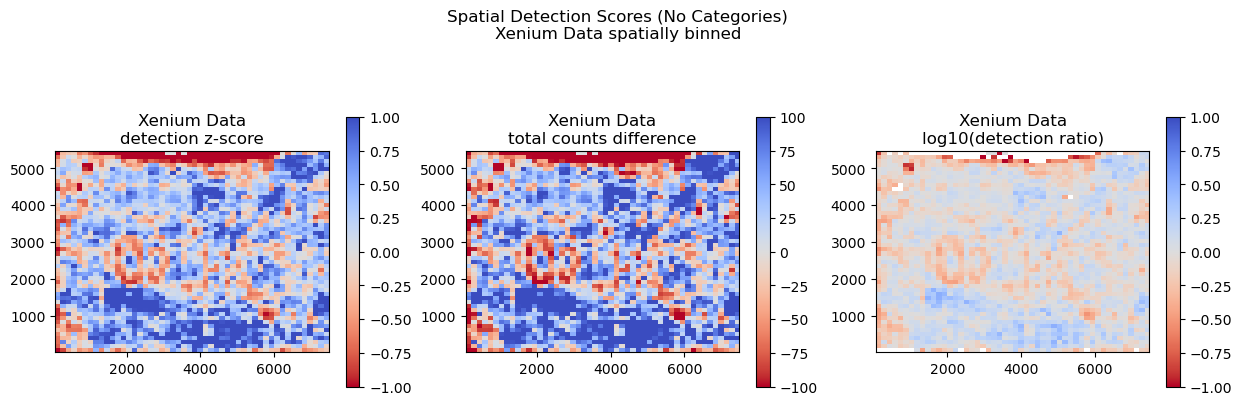

In [32]:
results = spatial_detection_scores_no_category(
    reference=reference_data,
    query=query_data,
    plot_stuff=True,
    query_name="Xenium Data",
    comparison_column="transcript_counts",
    n_bins=50,
    in_place=False,
    non_spatial=False
)